In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import squidpy as sq
import scanpy as sc
import os, shutil
from tqdm import tqdm
from transpa.eval_util import calc_corr, CalculateMeteics

import warnings
warnings.filterwarnings('ignore')

[Text(0, 0.5, 'Avg. Time (seconds)'),
 Text(0.5, 1.0, 'Average Training Time on 5-fold Cross Validataion')]

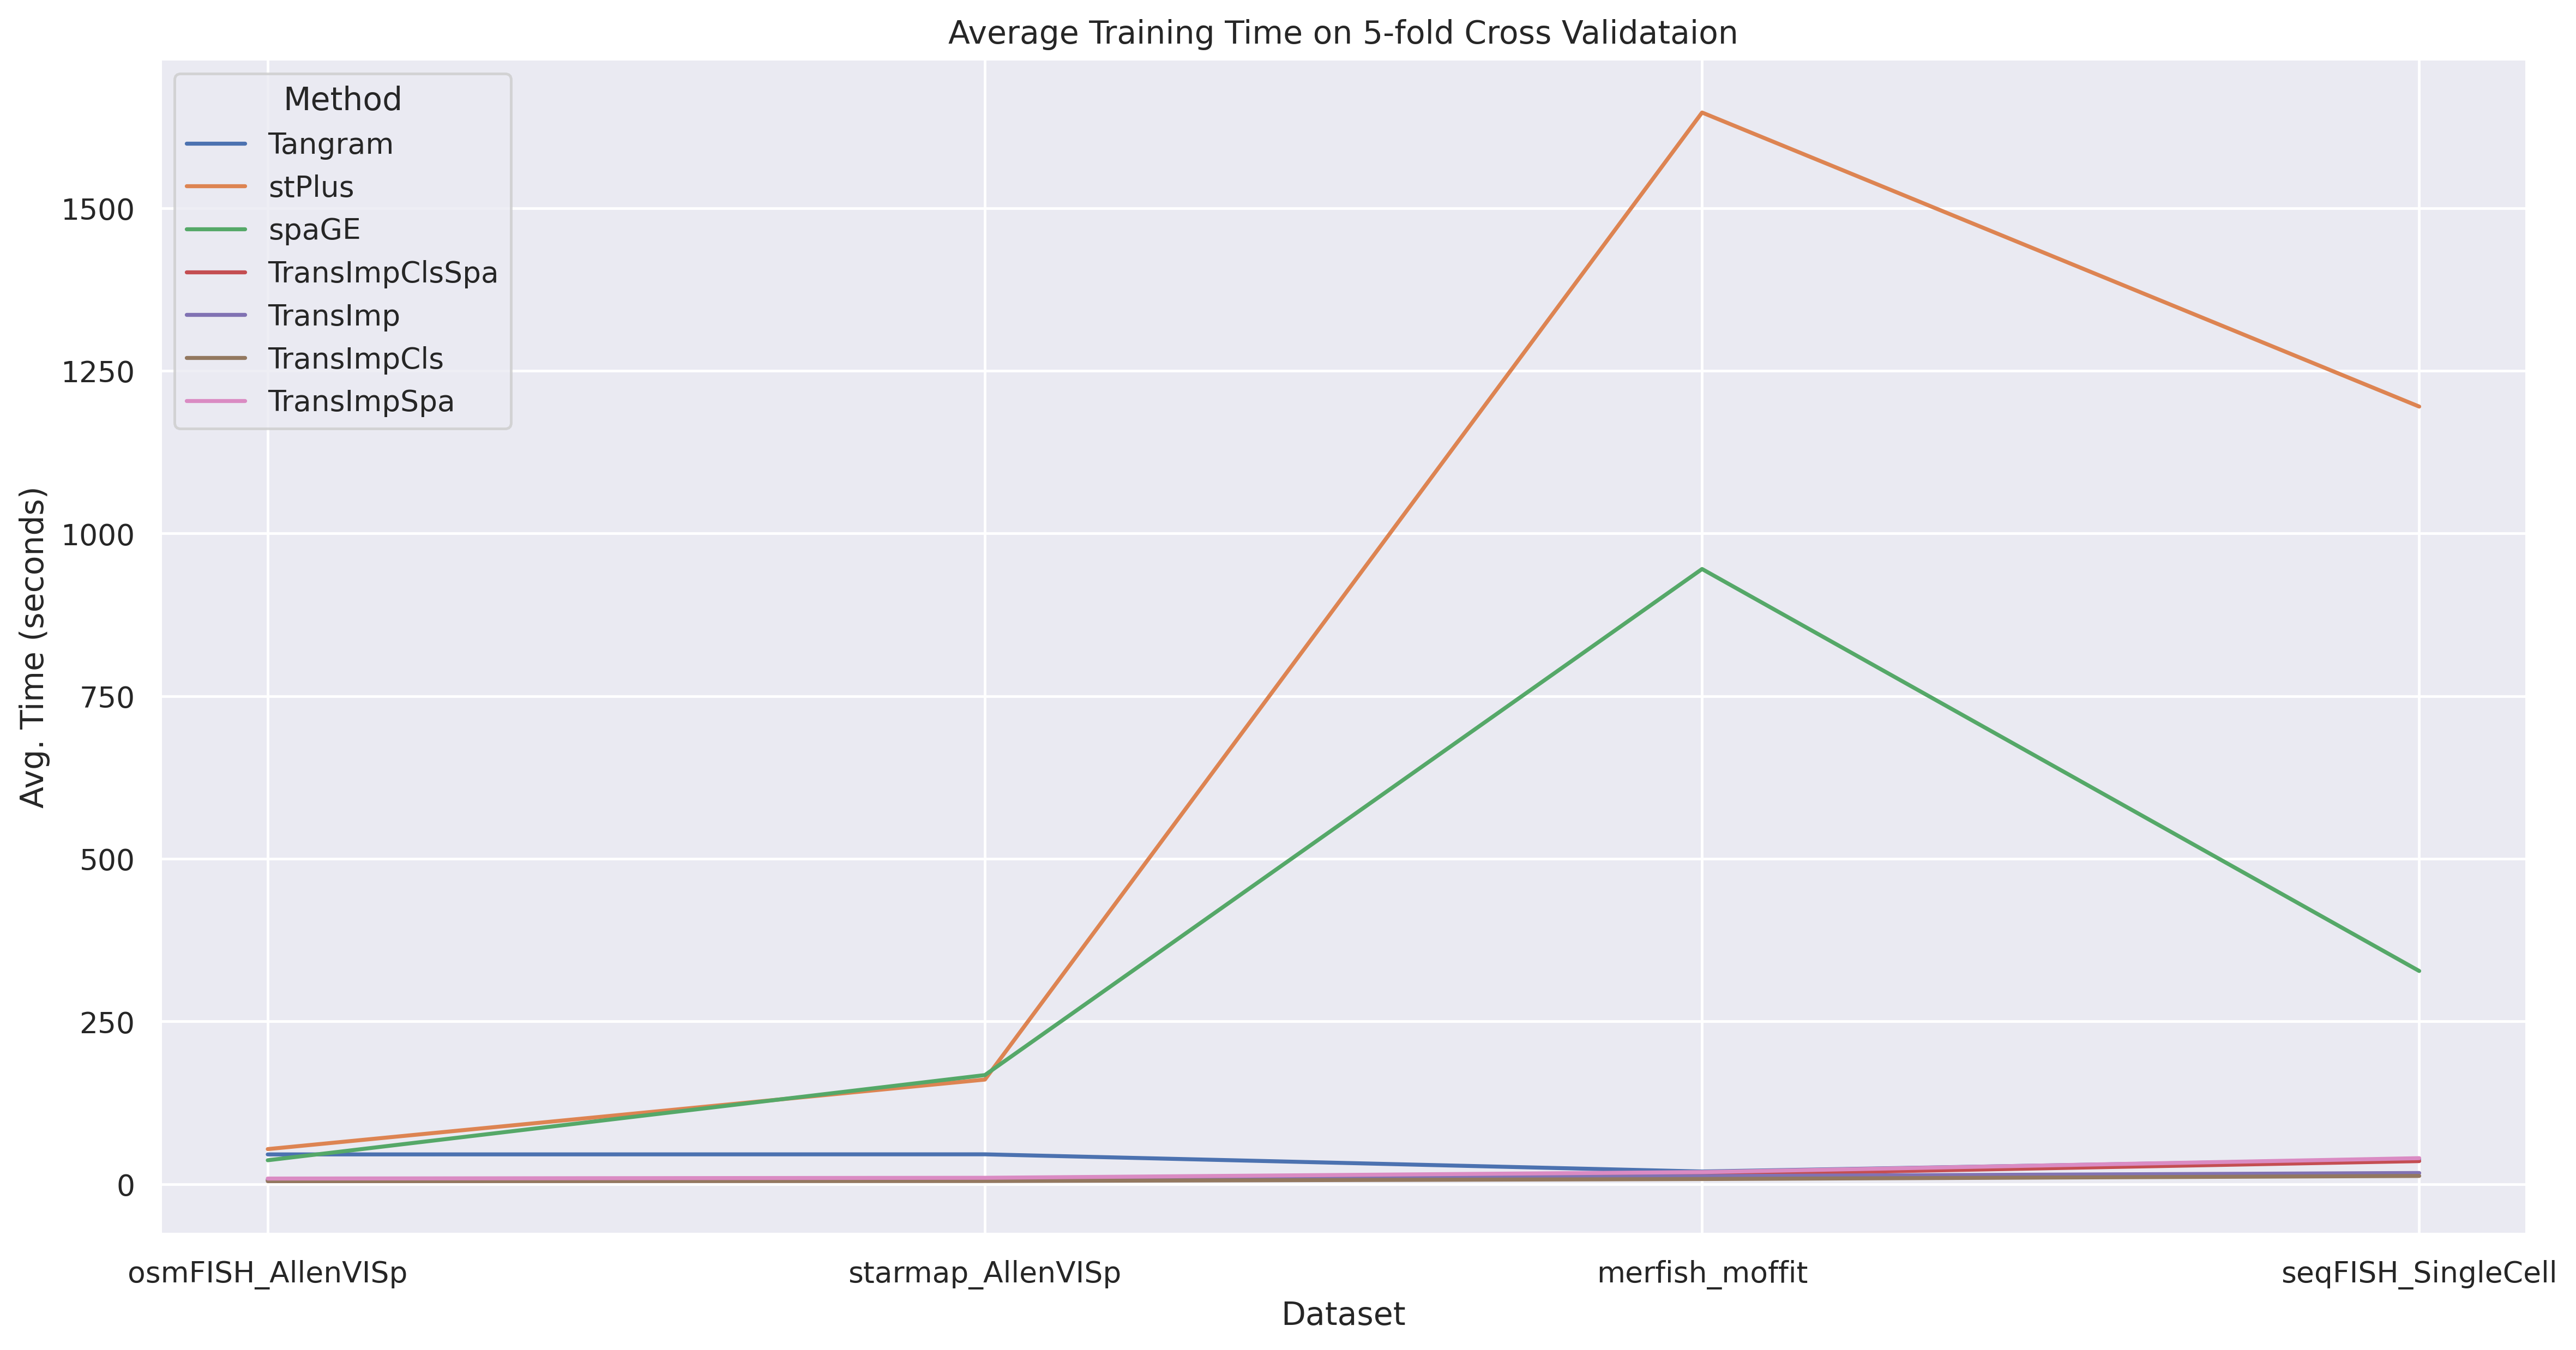

In [2]:
# efficiency
datasets = []
methods  = []
scores   = []
scale = []
with open('efficiency.out', 'r') as infile:
    for line in infile:
        if "Avg Runtime" in line:
            method = line.split(" ")[0]
            seconds = float(line.split(" ")[-1])
            methods.append(method)
            scores.append(seconds)
        elif "spa shape" in line:
            dataset = line.split(",")[0]
            n_spots = int(line.split("X")[0].strip().split(" ")[-1])
            n_cells = int(line.split("X")[1].strip().split(" ")[-1])
            scale.append(n_spots + n_cells)
            datasets.append(dataset)
df = pd.DataFrame(np.array([datasets, methods, scores, scale]).T, columns=['Dataset', 'Method', 'Time', 'Size'])
df.Time = df.Time.astype('float')
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})
order = ["osmFISH_AllenVISp", "starmap_AllenVISp", "merfish_moffit", "seqFISH_SingleCell"]
df = df.iloc[np.concatenate([np.argwhere(df.Dataset.values == dat).flatten() for dat in order])]
sns.lineplot(data=df, x='Dataset', y='Time', hue='Method', sort=False).set(
    ylabel="Avg. Time (seconds)",
    title="Average Training Time on 5-fold Cross Validataion"
)


In [3]:
methods, datasets = [], []
PCCs, SCCs, SSIMs, RMSEs, JSs = [], [], [], [], []
output_root = "../../output"
df_spas = {file.split('_')[0].lower():pd.read_csv(os.path.join(output_root, file), index_col=0) for file in os.listdir(output_root) if file.endswith('raw.csv')}

for file in os.listdir(output_root):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'transImpute', 'stPlus', 'Tangram', 'transImpSpa', 'transImpCls', 'transImpClsSpa'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue
    spa, rna, method = file.split(".")[0].split('_')
    if spa not in {"merfish", "osmFISH", "seqFISH", "starmap"}: continue
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    df_all_metrics = CalculateMeteics(raw_df=df_spas[spa.lower()][df_res.columns], imp_df=df_res).compute_all()
        
    datasets = datasets + [f'{spa}_{rna}'] * df_all_metrics.shape[1]
    methods = methods  + [method] * df_all_metrics.shape[1]
    PCCs.extend(df_all_metrics.loc['PCC'])
    SCCs.extend(df_all_metrics.loc['SCC'])
    SSIMs.extend(df_all_metrics.loc['SSIM'])
    RMSEs.extend(df_all_metrics.loc['RMSE'])
    JSs.extend(df_all_metrics.loc['JS'])
    print(file)

def assemble_metrics(metric_name, metric_vals):
    df_stats = pd.DataFrame(columns=['method', 'dataset', metric_name])
    df_stats.method = methods
    df_stats.dataset = datasets
    df_stats[metric_name] = metric_vals
    return df_stats

all_metric_dfs = {name:assemble_metrics(name, metric_vals) for name, metric_vals in zip(["PCC", "SCC", "SSIM", "RMSE", "JS"], [PCCs, SCCs, SSIMs, RMSEs, JSs])}

    

osmFISH_AllenVISp_transImpClsSpa.csv
starmap_AllenVISp_transImpSpa.csv
osmFISH_AllenVISp_transImpSpa.csv
merfish_moffit_transImpute.csv
seqFISH_SingleCell_stPlus.csv
osmFISH_AllenVISp_stPlus.csv
merfish_moffit_transImpCls.csv
merfish_moffit_Tangram.csv
seqFISH_SingleCell_transImpClsSpa.csv
seqFISH_SingleCell_transImpSpa.csv
starmap_AllenVISp_transImpute.csv
seqFISH_SingleCell_transImpCls.csv
starmap_AllenVISp_spaGE.csv
osmFISH_AllenVISp_Tangram.csv
osmFISH_AllenVISp_transImpute.csv
merfish_moffit_transImpSpa.csv
starmap_AllenVISp_stPlus.csv
osmFISH_AllenVISp_spaGE.csv
merfish_moffit_stPlus.csv
merfish_moffit_spaGE.csv
seqFISH_SingleCell_spaGE.csv
merfish_moffit_transImpClsSpa.csv
starmap_AllenVISp_transImpClsSpa.csv
osmFISH_AllenVISp_transImpCls.csv
seqFISH_SingleCell_Tangram.csv
starmap_AllenVISp_Tangram.csv
starmap_AllenVISp_transImpCls.csv
seqFISH_SingleCell_transImpute.csv


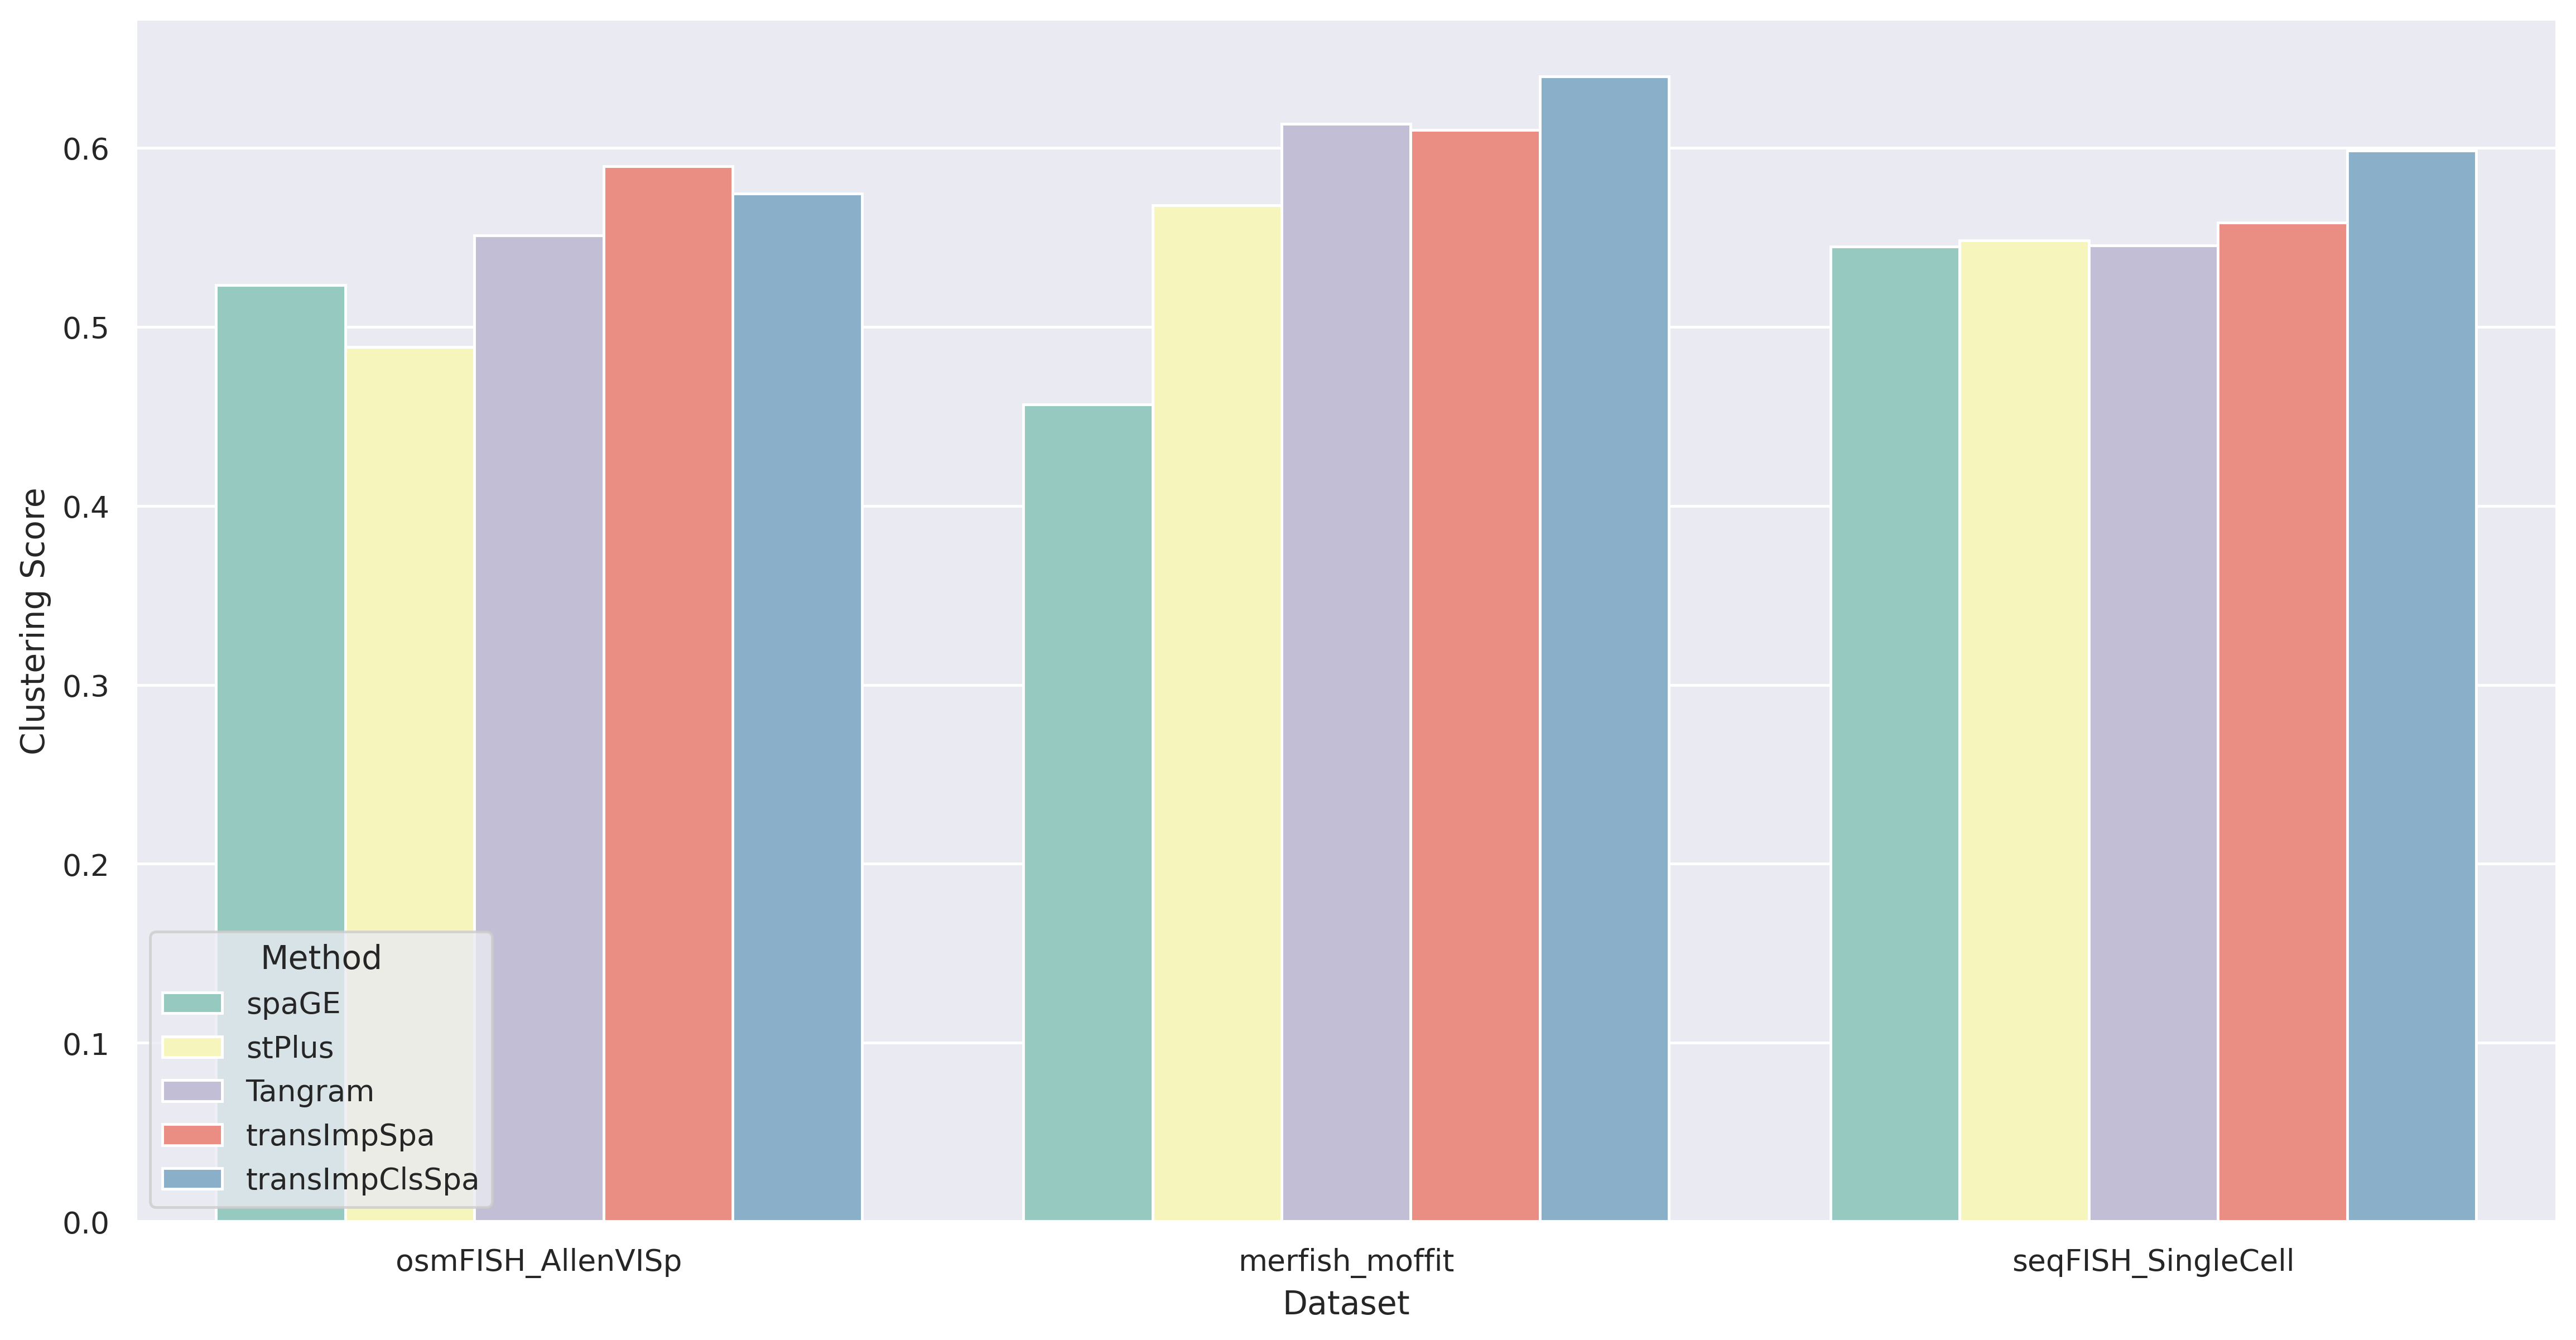

In [4]:
df_res = None
for file in os.listdir('../../output/clustering/'):
    if len(file.split(".")[0].split('_')) != 2: continue
    spa, rna = file.split(".")[0].split('_')
    if spa not in {"merfish", "osmFISH", "seqFISH", "starmap"}: continue
    
    df = pd.read_csv(os.path.join('../../output/clustering',file), index_col=0)
    _df = pd.DataFrame()
    sel = np.ones(df.shape[1], dtype=bool)
    sel[df.columns == "transImpCls"] = False
    sel[df.columns == "transImpute"] = False
    _df['Clustering Score'] = np.mean(df.values, axis=0)[sel]
    _df['Method'] = df.columns[sel]
    _df['Dataset'] = f"{spa}_{rna}"
    if not df_res is None:
        df_res = pd.concat([df_res, _df])
    else:
        df_res = _df

dataset_order = ["osmFISH_AllenVISp", "merfish_moffit", "seqFISH_SingleCell"]
df_res = df_res.iloc[np.concatenate([np.argwhere(df_res.Dataset.values == dat).flatten() for dat in dataset_order])]
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})


sns.barplot(data=df_res, x='Dataset', order=dataset_order, y='Clustering Score', hue='Method', hue_order=['spaGE', 'stPlus', 'Tangram', "transImpSpa", "transImpClsSpa"], palette ='Set3')
plt.legend(loc='lower left', title='Method')

In [5]:
methods, datasets = [], []
correlations = []
df_spas = {file.split('_')[0].lower():pd.read_csv(os.path.join('../../output', file), index_col=0) for file in os.listdir('../../output') if file.endswith('raw.csv')}

for file in os.listdir('../../output'):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'transImpute', 'stPlus', 'Tangram', 'transImpSpa', 'transImpCls', 'transImpClsSpa'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue
    spa, rna, method = file.split(".")[0].split('_')
    if spa not in {"merfish", "osmFISH", "seqFISH", "starmap"}: continue
    df_res = pd.read_csv(os.path.join('../../output',file), index_col=0)
    
    corrs = calc_corr(df_spas[spa.lower()], df_res, df_res.columns)
    datasets = datasets + [f'{spa}_{rna}'] * len(corrs)
    methods = methods  + [method] * len(corrs)
    correlations.extend(corrs)
    print(file)
df_stats = pd.DataFrame(columns=['method', 'dataset', 'spearmanr'])
df_stats.method = methods
df_stats.dataset = datasets
df_stats.spearmanr = correlations
df_stats

osmFISH_AllenVISp_transImpClsSpa.csv
starmap_AllenVISp_transImpSpa.csv
osmFISH_AllenVISp_transImpSpa.csv
merfish_moffit_transImpute.csv
seqFISH_SingleCell_stPlus.csv
osmFISH_AllenVISp_stPlus.csv
merfish_moffit_transImpCls.csv
merfish_moffit_Tangram.csv
seqFISH_SingleCell_transImpClsSpa.csv
seqFISH_SingleCell_transImpSpa.csv
starmap_AllenVISp_transImpute.csv
seqFISH_SingleCell_transImpCls.csv
starmap_AllenVISp_spaGE.csv
osmFISH_AllenVISp_Tangram.csv
osmFISH_AllenVISp_transImpute.csv
merfish_moffit_transImpSpa.csv
starmap_AllenVISp_stPlus.csv
osmFISH_AllenVISp_spaGE.csv
merfish_moffit_stPlus.csv
merfish_moffit_spaGE.csv
seqFISH_SingleCell_spaGE.csv
merfish_moffit_transImpClsSpa.csv
starmap_AllenVISp_transImpClsSpa.csv
osmFISH_AllenVISp_transImpCls.csv
seqFISH_SingleCell_Tangram.csv
starmap_AllenVISp_Tangram.csv
starmap_AllenVISp_transImpCls.csv
seqFISH_SingleCell_transImpute.csv


,method,dataset,spearmanr
0,transImpClsSpa,osmFISH_AllenVISp,0.012469
1,transImpClsSpa,osmFISH_AllenVISp,0.197732
2,transImpClsSpa,osmFISH_AllenVISp,0.134669
3,transImpClsSpa,osmFISH_AllenVISp,0.191074
4,transImpClsSpa,osmFISH_AllenVISp,0.250537
...,...,...,...
10712,transImpute,seqFISH_SingleCell,0.111534
10713,transImpute,seqFISH_SingleCell,0.084198
10714,transImpute,seqFISH_SingleCell,0.219984
10715,transImpute,seqFISH_SingleCell,0.232486


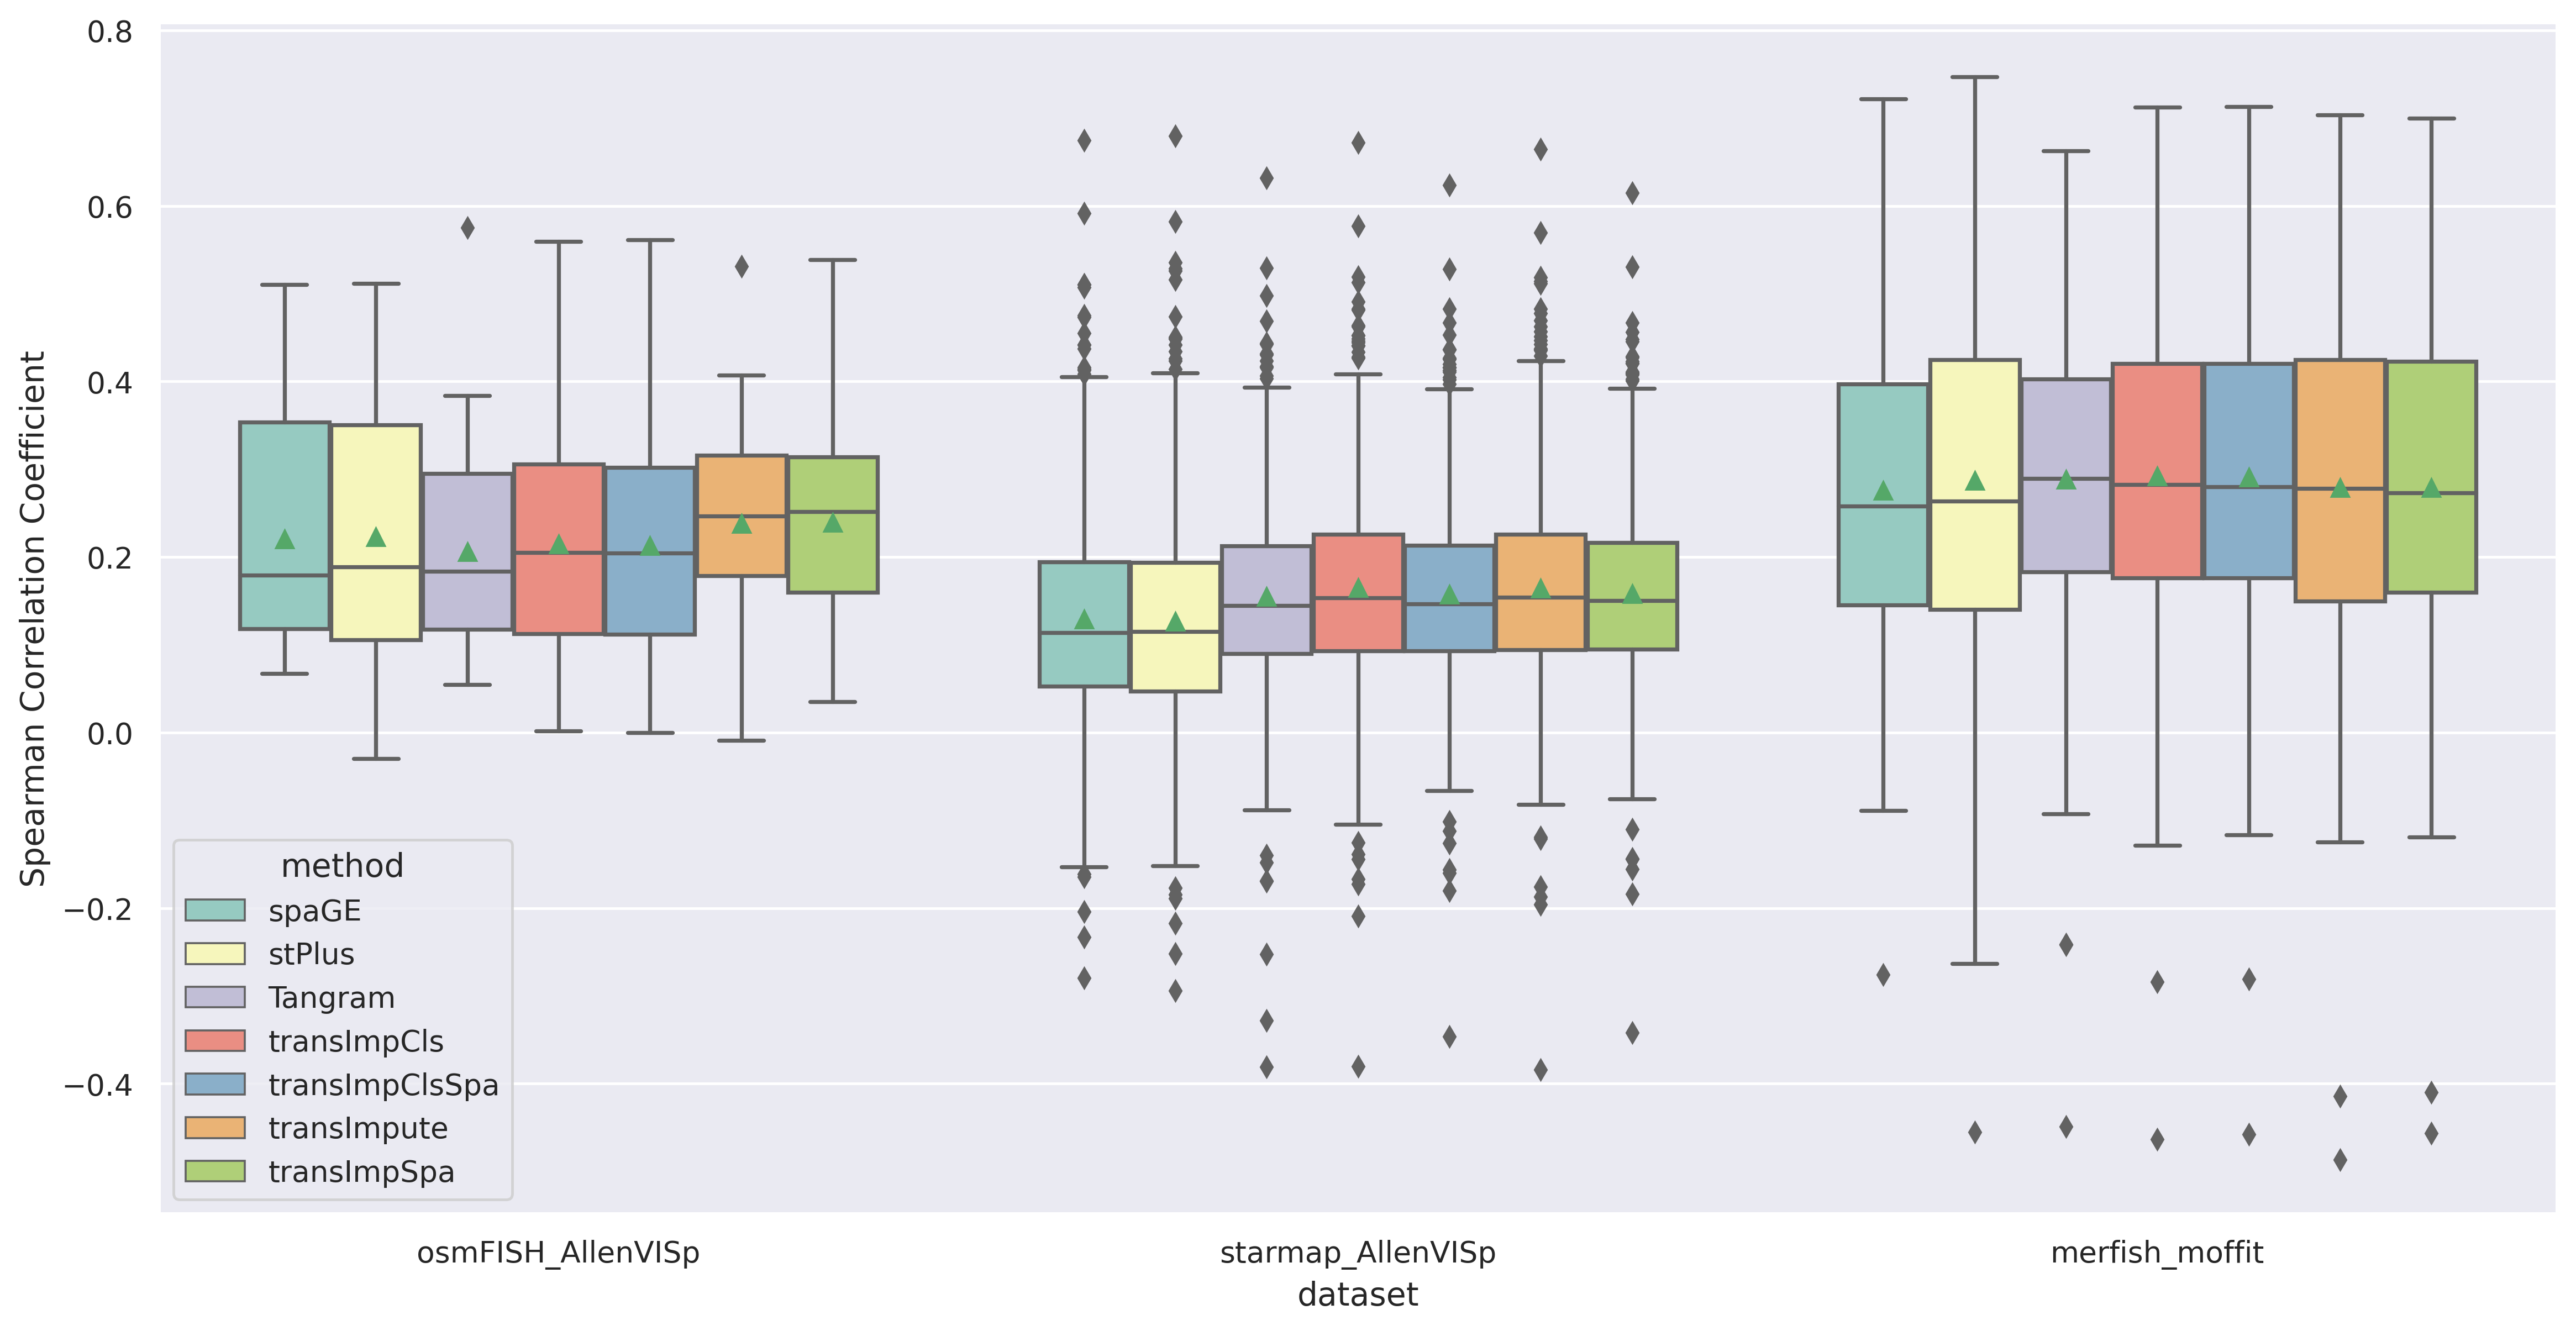

In [6]:
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})
data_order = ["osmFISH_AllenVISp", "starmap_AllenVISp", "merfish_moffit"]
method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
df_res = df_stats.iloc[np.concatenate([np.argwhere(df_stats.dataset.values == dat).flatten() for dat in data_order])]
ax = sns.boxplot(x="dataset", y="spearmanr", hue="method",order=data_order, hue_order=method_order,
                 data=df_res, palette="Set3", showmeans=True).set(
    ylabel='Spearman Correlation Coefficient'
)

In [7]:
methods, datasets = [], []
squ_err_moranIs, squ_err_gearyCs = [], []
correlations = []
df_spas = {file.split('_')[0].lower():pd.read_csv(os.path.join('../../output', file), index_col=0) for file in os.listdir('../../output') if file.endswith('raw.csv')}
loc_spas = {file.split('_')[0].lower():np.load(os.path.join('../../output', file)) for file in os.listdir('../../output') if file.endswith('locations.npy')}
adata_spas = {}

for spa_name in df_spas:
    adata_spas[spa_name] = sc.AnnData(df_spas[spa_name].values)
    adata_spas[spa_name].var_names = df_spas[spa_name].columns
    adata_spas[spa_name].obsm['spatial'] = loc_spas[spa_name]
    
    sq.gr.spatial_neighbors(adata_spas[spa_name])
    sq.gr.spatial_autocorr(
        adata_spas[spa_name],
        n_jobs=10,
        mode='moran',
    )
    sq.gr.spatial_autocorr(
        adata_spas[spa_name],
        n_jobs=10,
        mode='geary',
    )    


for file in os.listdir('../../output'):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'transImpute', 'stPlus', 'Tangram', 'transImpSpa', 'transImpCls', 'transImpClsSpa'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue
    spa, rna, method = file.split(".")[0].split('_')
    if spa not in {"merfish", "osmFISH", "seqFISH", "starmap"}: continue
    spa_adata = adata_spas[spa.lower()]

    df_res = pd.read_csv(os.path.join('../../output',file), index_col=0)
    imp_adata = sc.AnnData(df_res.values)
    imp_adata.var_names = df_res.columns
    imp_adata.obsm['spatial'] = spa_adata.obsm['spatial']
    sq.gr.spatial_neighbors(imp_adata)
    sq.gr.spatial_autocorr(
        imp_adata,
        n_jobs=10,
        mode='moran',
    )
    sq.gr.spatial_autocorr(
        imp_adata,
        n_jobs=10,
        mode='geary',
    )   
    
    sel = (~np.isnan(imp_adata.uns['moranI'].I)) & (~np.isnan(imp_adata.uns['gearyC'].C))
    if np.sum(sel) < imp_adata.n_vars:
        print(f'({spa} {rna} {method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I[sel] - imp_adata.uns['moranI'].I[sel])
    squ_err_gearyC = np.square(spa_adata.uns['gearyC'].loc[imp_adata.var_names].C[sel] - imp_adata.uns['gearyC'].C[sel])
    datasets = datasets + [f'{spa}_{rna}'] * len(squ_err_moranI)
    methods = methods  + [method] * len(squ_err_moranI)
    squ_err_moranIs.extend(squ_err_moranI)
    squ_err_gearyCs.extend(squ_err_gearyC)
    print(file)
df_stats_spa = pd.DataFrame(columns=['method', 'dataset', 'err2_moranI', 'err2_gearyC'])
df_stats_spa.method = methods
df_stats_spa.dataset = datasets
df_stats_spa.err2_moranI = squ_err_moranIs
df_stats_spa.err2_gearyC = squ_err_gearyCs

osmFISH_AllenVISp_transImpClsSpa.csv
starmap_AllenVISp_transImpSpa.csv
osmFISH_AllenVISp_transImpSpa.csv
merfish_moffit_transImpute.csv
seqFISH_SingleCell_stPlus.csv
osmFISH_AllenVISp_stPlus.csv
merfish_moffit_transImpCls.csv
merfish_moffit_Tangram.csv
seqFISH_SingleCell_transImpClsSpa.csv
seqFISH_SingleCell_transImpSpa.csv
starmap_AllenVISp_transImpute.csv
seqFISH_SingleCell_transImpCls.csv
starmap_AllenVISp_spaGE.csv
osmFISH_AllenVISp_Tangram.csv
osmFISH_AllenVISp_transImpute.csv
merfish_moffit_transImpSpa.csv
starmap_AllenVISp_stPlus.csv
osmFISH_AllenVISp_spaGE.csv
merfish_moffit_stPlus.csv
merfish_moffit_spaGE.csv
seqFISH_SingleCell_spaGE.csv
merfish_moffit_transImpClsSpa.csv
starmap_AllenVISp_transImpClsSpa.csv
osmFISH_AllenVISp_transImpCls.csv
seqFISH_SingleCell_Tangram.csv
starmap_AllenVISp_Tangram.csv
starmap_AllenVISp_transImpCls.csv
seqFISH_SingleCell_transImpute.csv


[Text(0, 0.5, "Mean Squared Error of Moran's I")]

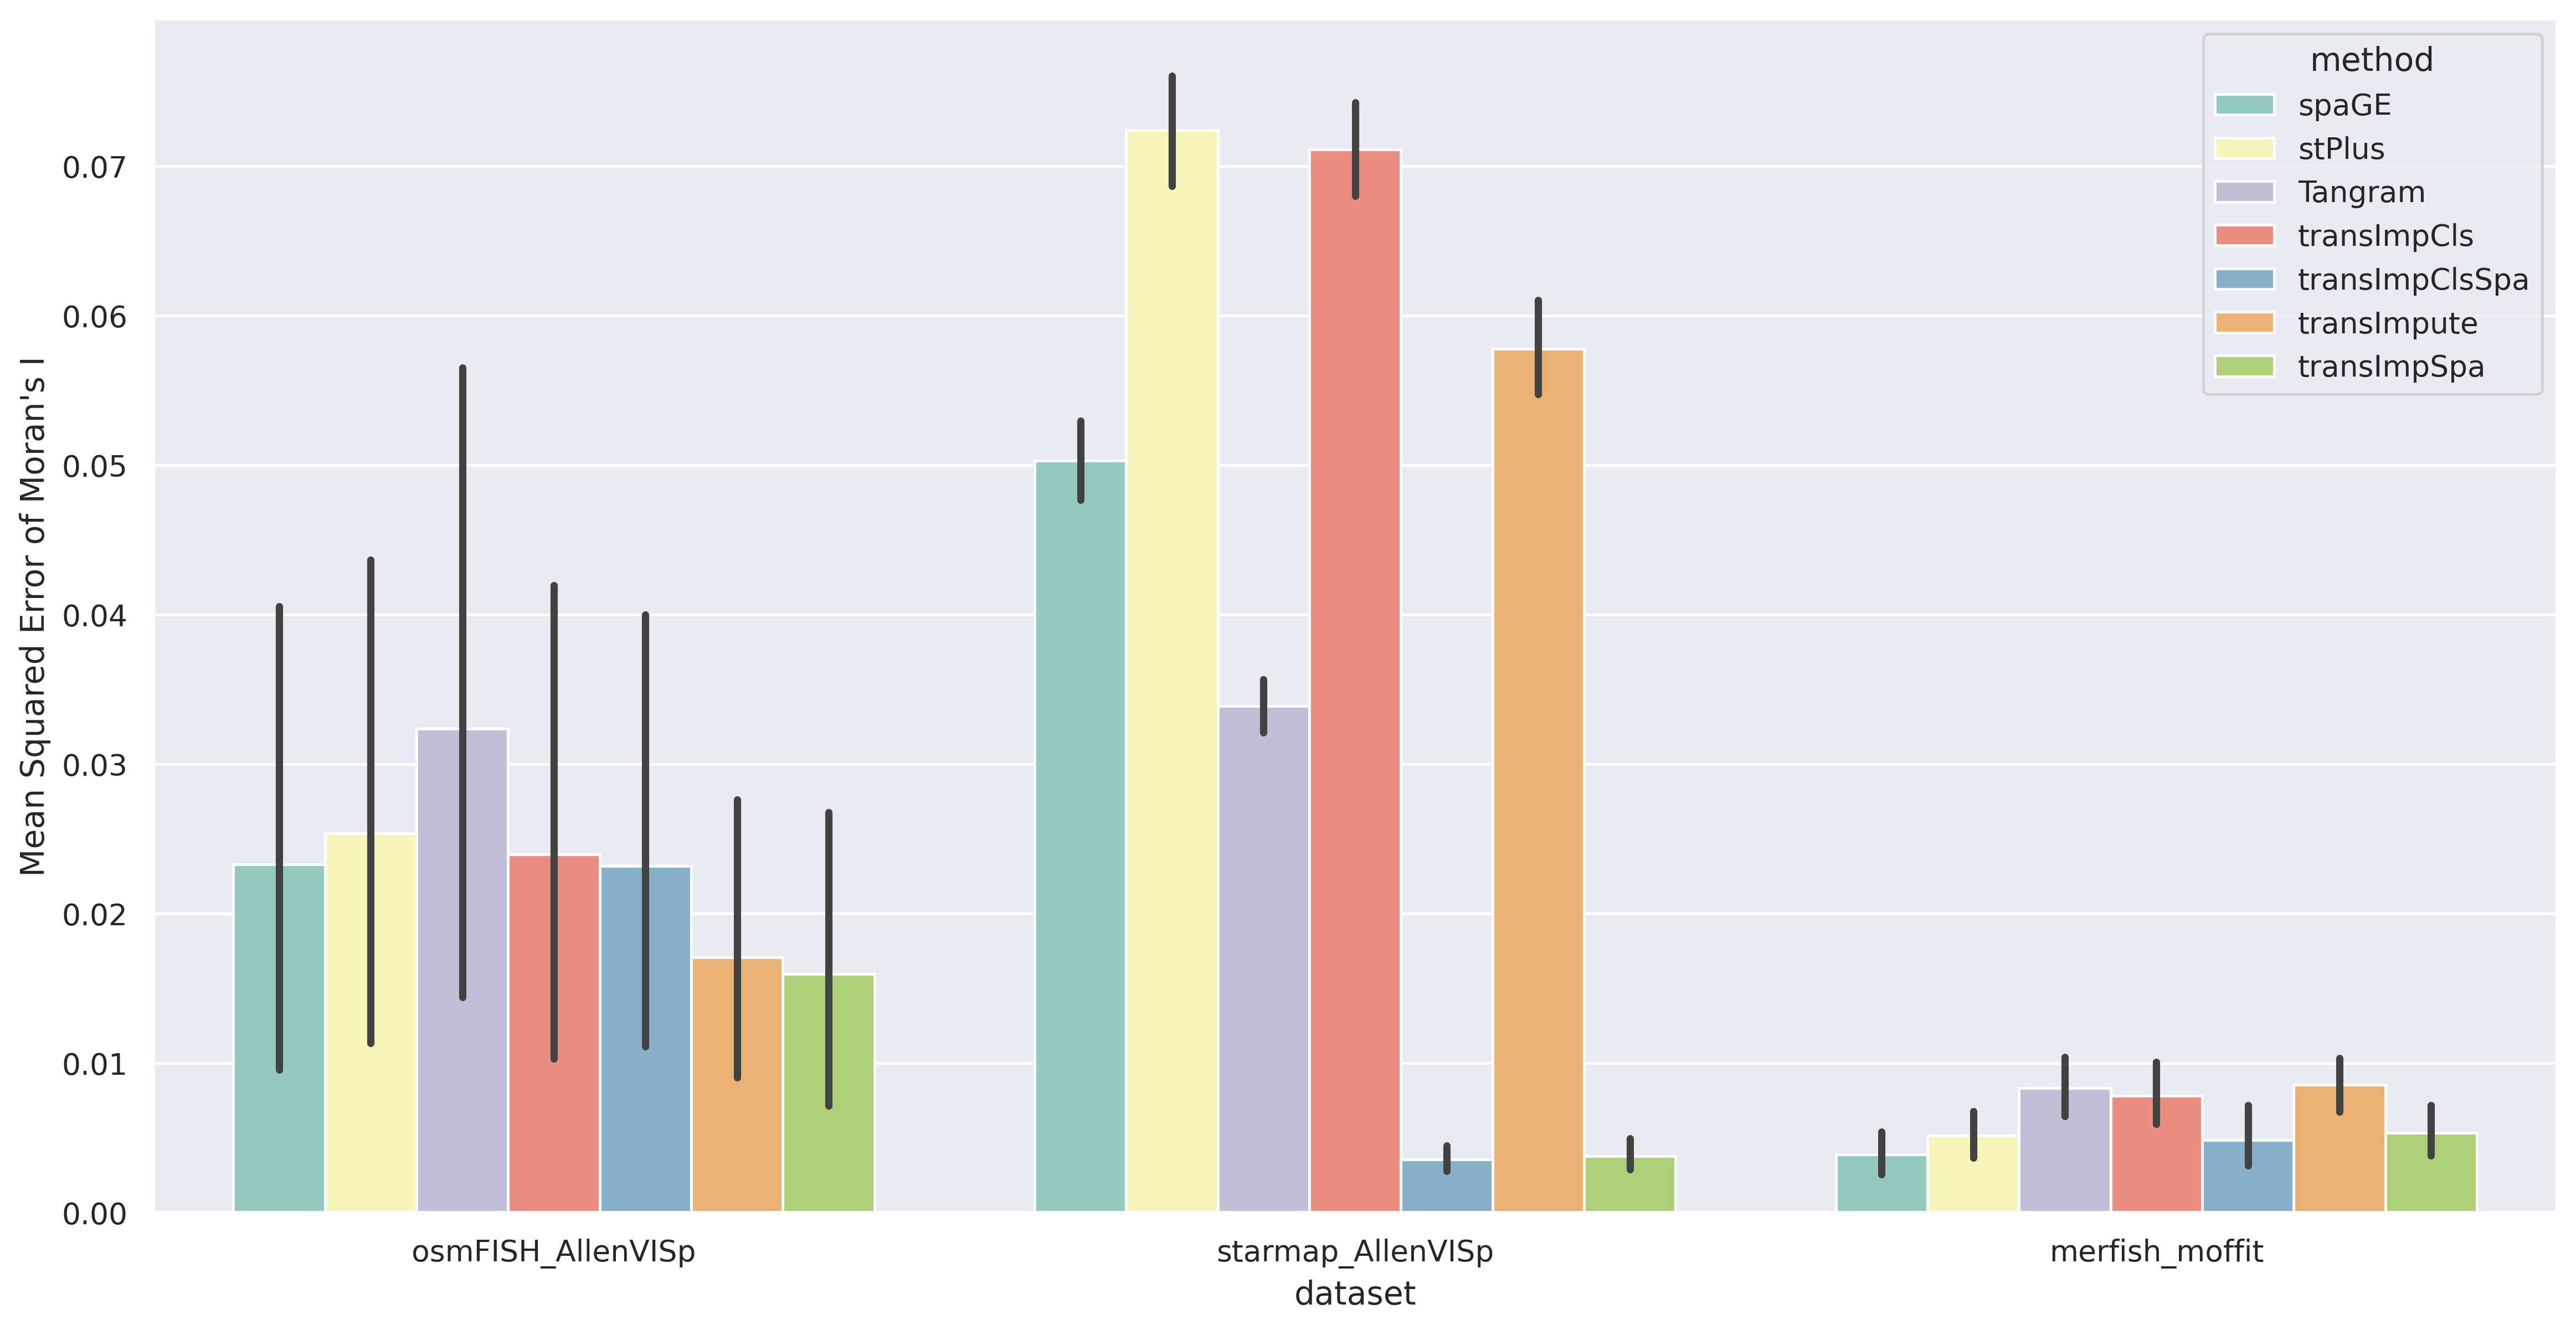

In [8]:
df_res = df_stats_spa.iloc[np.concatenate([np.argwhere(df_stats_spa.dataset.values == dat).flatten() for dat in data_order])]
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})

data_order = ["osmFISH_AllenVISp", "starmap_AllenVISp", "merfish_moffit"]
method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
sns.barplot(x = "dataset", y = "err2_moranI", hue="method", order=data_order, hue_order=method_order, data = df_res, ci = 95, palette ='Set3').set(
    ylabel="Mean Squared Error of Moran's I"
)
